[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/ml/06_dt.ipynb)

# Árboles de Decisión

## Entrenamiento y visualización

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

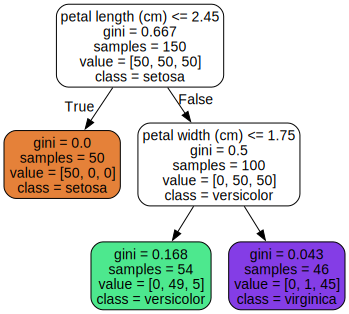

In [2]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file("iris_tree.dot")

Para hacer predicciones en un árbol de decisión, comenzamos en el nodo *raíz* y preguntamos si la longitud del pétalo es menor que 2.45 cm. Si lo es, nos movemos al nodo izquierdo. Como es un nodo *terminal*, asignamos la misma clase a la instancia. Si tomamos otra instancia con una longitud de pétalo mayor a 2.45 cm, nos movemos al nodo derecho. Como no es un nodo terminal, hacemos otra pregunta, en este caso ¿es el ancho del pétalo menor que 1.75 cm? Si lo es, asignamos la clase del nodo hijo izquierdo. Si no, asignamos la clase del nodo hijo derecho (ambos son nodos terminales).

Los árboles de decisión pueden trabajar con conjuntos de datos muy pequeños y no requieren escalado o normalización de características. Además, son uno de los pocos algoritmos en la caja de herramientas de ML que tienen buena interpretabilidad.

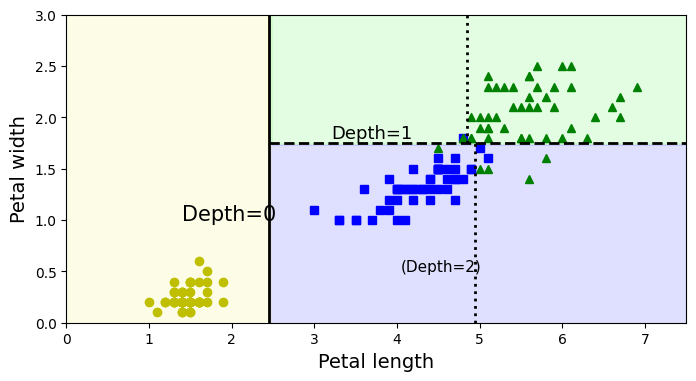

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

Un árbol de decisión puede estimar la probabilidad de que una instancia pertenezca a una clase particular. Primero, debemos encontrar el nodo terminal para esa instancia. Luego, devolvemos la proporción de instancias de entrenamiento de la clase particular en este nodo.


In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

## El Algoritmo CART

El algoritmo *Classification and Regression Tree* (CART) es utilizado por Scikit-Learn para entrenar árboles de decisión. Funciona dividiendo el conjunto de entrenamiento en dos subconjuntos utilizando una sola característica $k$ y un umbral $t_k$. ¿Qué clase y umbral usar? El par que produce los subconjuntos más puros.

La pureza de un nodo se mide con el valor de *impureza de Gini*

$$
  G_i = 1 - \sum_{k=1}^n p_{i,k}^2
$$

donde $p_{i,k}$ es la proporción de instancias de clase $k$ entre las instancias de entrenamiento en el nodo $i$-ésimo y $n$ es el número de clases.

La función de coste CART para clasificación se define de la siguiente manera:

$$
  J(k, t_k) = \frac{m_{\textrm{izquierda}}}{m} G_{\textrm{izquierda}} + \frac{m_{\textrm{derecha}}}{m} G_{\textrm{derecha}}
$$

donde $G_{\textrm{izquierda}/\textrm{derecha}}$ mide la impureza del subconjunto izquierdo/derecho y $m_{\textrm{izquierda}/\textrm{derecha}}$ es el número de instancias en el subconjunto izquierdo/derecho.

Una vez que el algoritmo ha dividido con éxito el conjunto de entrenamiento en dos, repite el mismo proceso iterativamente para cada subconjunto hasta que alcanza una profundidad máxima predefinida o no se puede encontrar una nueva división que reduzca la impureza.

## Regularización

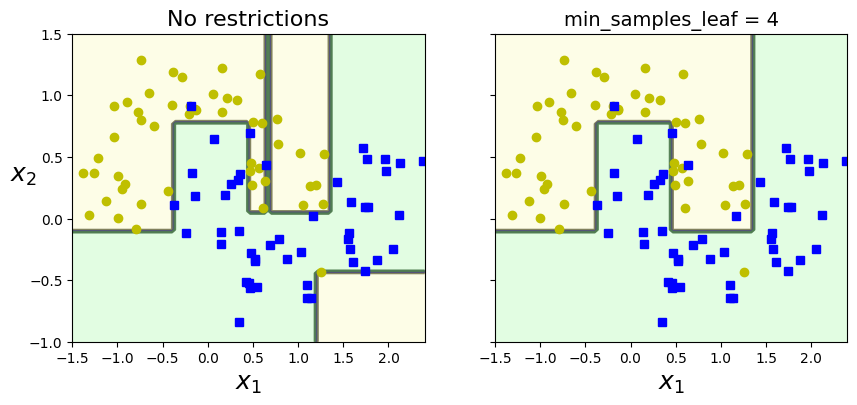

In [6]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")
plt.show()

## Regresión

In [7]:
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

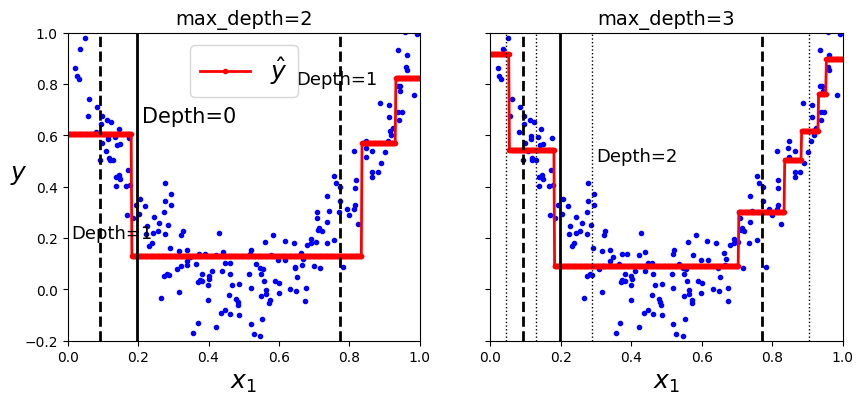

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

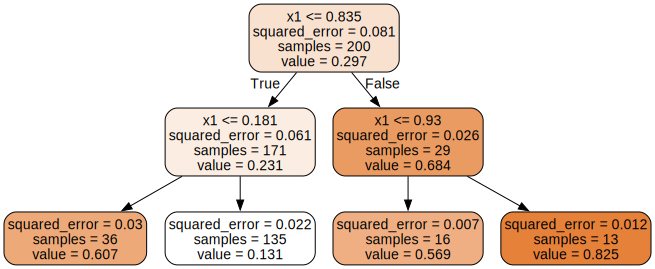

In [9]:
export_graphviz(
        tree_reg1,
        out_file="regression_tree.dot",
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file("regression_tree.dot")

La idea es la misma que antes, pero ahora cada nodo hoja tiene asignado un valor que es el promedio de todas las instancias que pertenecen al nodo.

Para entrenar árboles de decisión de regresión podemos usar el algoritmo CART, pero en lugar de minimizar la impureza ahora minimizamos el MSE.

$$
  J(k, t_k) = \frac{m_{\textrm{izquierda}}}{m} MSE_{\textrm{izquierda}} + \frac{m_{\textrm{derecha}}}{m} MSE_{\textrm{derecha}}
$$

donde $MSE_{\textrm{nodo}} = \sum_{i \in \textrm{nodo}} (\hat{y}_{\textrm{nodo}} - y^{(i)})^2$ y $\hat{y}_{\textrm{nodo}} = \frac{1}{m_{\textrm{nodo}}} \sum_{i \in \textrm{nodo}} y^{(i)}$.

Al igual que en la clasificación, los árboles de decisión son propensos al sobreajuste en tareas de regresión.

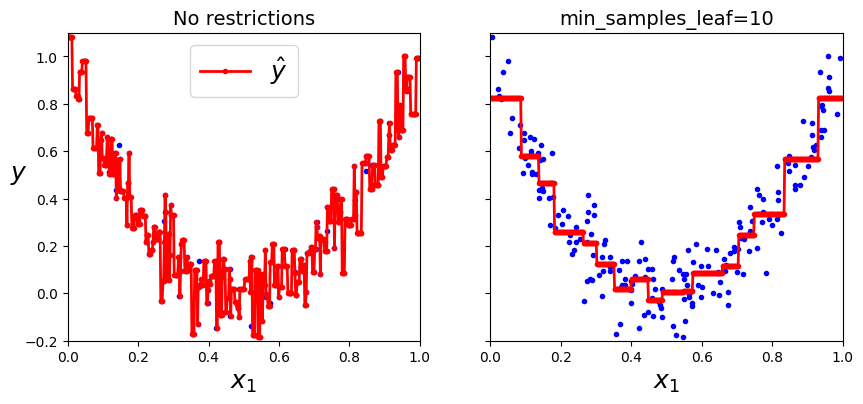

In [10]:

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

## Limitaciones

Los árboles de decisión tienen muchas ventajas: son simples de entender e interpretar, fáciles de usar, versátiles y poderosos. Sin embargo, son muy sensibles a pequeñas variaciones en los datos de entrenamiento.

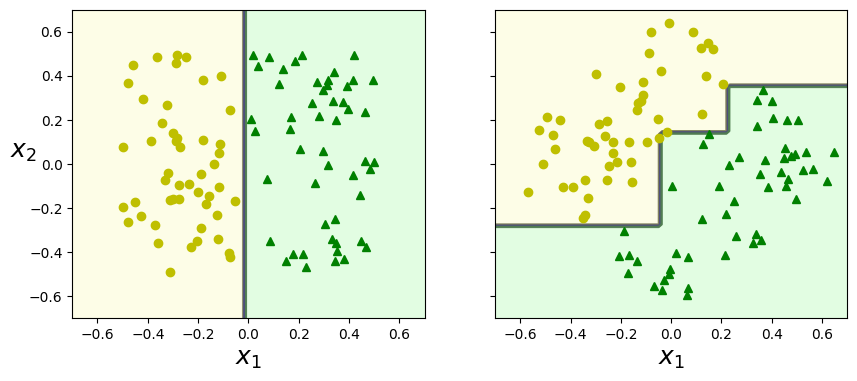

In [11]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")
plt.show()

Este problema puede ser mitigado utilizando PCA para obtener una mejor orientación de los datos.

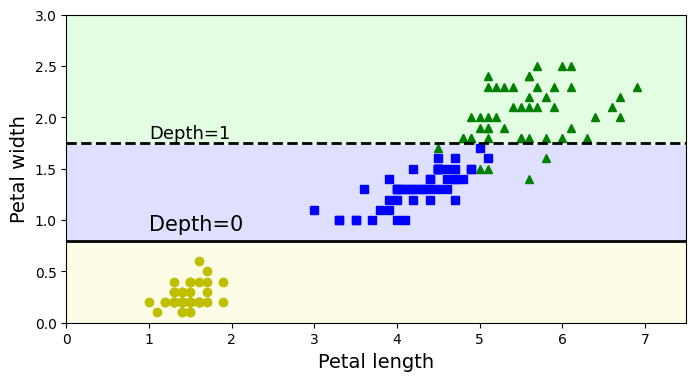

In [12]:
X = iris.data[:, 2:] # petal length and width
y = iris.target

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.show()

O mediante el uso de Random Forests.